In [130]:
# modules for data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 


# 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# modules for modeling
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.linear_model import LogisticRegression, SGDRegressor, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [119]:
df = pd.read_csv(r'/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [120]:
df['sentiment_flg'] = np.where(df['sentiment'].str.contains('positive'), 1, 0)
df.drop(columns='sentiment', inplace=True)

In [121]:
feat_model = TfidfVectorizer()
encoded = feat_model.fit_transform(df['review'])

x_train, x_test, y_train, y_test = train_test_split(
    encoded, 
    df['sentiment_flg'], 
    test_size=0.8, 
    random_state=42
)

In [127]:
model = LogisticRegression(solver='saga', max_iter=500, n_jobs=1)
# model.fit(x_train, y_train)
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

grid_search = RandomizedSearchCV(model, params_grid, cv=5, scoring='f1', verbose=2)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.1s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time= 1.6min


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time= 1.6min


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time= 1.5min


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time= 1.6min


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time= 1.6min
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ....................................C=1, penalty=l2; total time=   0.5s
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ....................................C=1, penalty=l2; total time=   0.4s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.5s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.4s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.4s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.5s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.5s
[CV] END ..................................C=100, penalty=l2; total time=   4.9s
[CV] END ...................

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=500, n_jobs=1,
                                                solver='saga'),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2']},
                   scoring='f1', verbose=2)

In [133]:
print(f"Лучшее значение C: {grid_search.best_params_}")
print(f"Лучший F1-score: {grid_search.best_score_:.4f}")

model = grid_search.best_estimator_

Лучшее значение C: {'penalty': 'l2', 'C': 10}
Лучший F1-score: 0.8779


In [134]:
y_pred = model.predict(x_test)

print(f'Classification Report: {classification_report(y_test, y_pred)}')

Classification Report:               precision    recall  f1-score   support

           0       0.89      0.87      0.88     19996
           1       0.87      0.90      0.88     20004

    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88     40000



<Axes: >

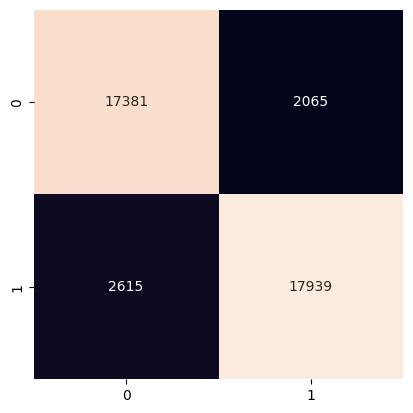

In [135]:
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

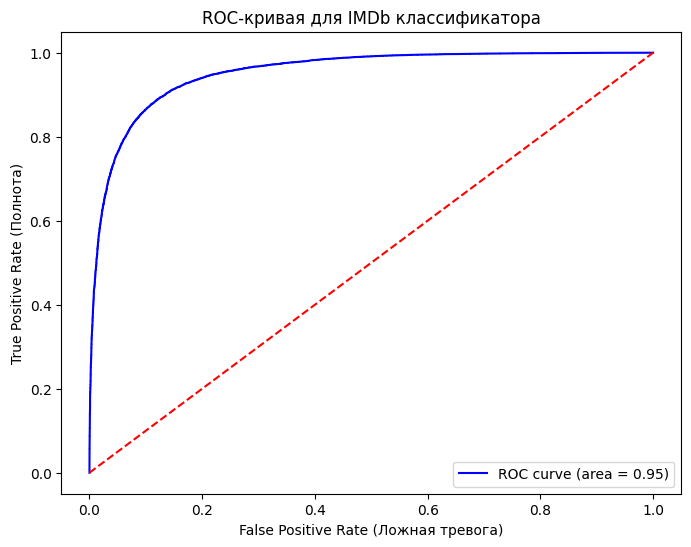

In [137]:
model = grid_search.best_estimator_
y_probs = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 3. Визуализация
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Линия случайного гадания
plt.xlabel('False Positive Rate (Ложная тревога)')
plt.ylabel('True Positive Rate (Полнота)')
plt.title('ROC-кривая для IMDb классификатора')
plt.legend(loc="lower right")
plt.show()